## What I have done
1. Pair the datasets from kaggle with their categories(Human or other species) according to the wiki.
2. Use girvan_newman algorithm to detect communities
3. Assess homophily of human and other species

## Results
1. 10-communities has the highest modularity_scores
2. The similarity score is very low

In [1]:
# import packages
import pandas as pd
import numpy as np
import json
import itertools
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
import networkx as nx
from networkx.algorithms.community import girvan_newman, modularity

In [10]:
# the class that pair the character name with  their role(human or not human) according to wiki
class StarWarsCharacter:
    """
    For get the category of each character
    """

    def __init__(self):
        with open('./starwars-full-interactions-allCharacters.json') as f:
            self.data = json.load(f)
        res = requests.get("https://en.wikipedia.org/wiki/List_of_Star_Wars_characters").text
        self.soup = BeautifulSoup(res)
        self.tables = self.soup.find_all("table", class_='wikitable')
        self.human_name_list = []
        self.other_species_name_list = []

    def get_labeled_characters(self):
        """
        Get the character type from wiki
        :return:
        """
        print("Start to get character type")
        self._category_characters()
        final_data = self.data.copy()
        final_data[0] = self._label_characters()
        return final_data

    @staticmethod
    def _parse_name_from_table(table):
        name_list = []
        for row in table.find_all("tr"):
            try:
                name = row.find_all("td")[0].text
                name_list.append(name.replace("\n", ""))
            except:  # maybe this row is theader or comment
                pass
        return name_list

    def _category_characters(self):
        for count, table in enumerate(self.tables):
            name_list = self._parse_name_from_table(table)
            # first 22 tables contain human names
            if count <= 21:
                self.human_name_list.extend(name_list)
            # after the 23rd table, they are all other species
            else:
                self.other_species_name_list.extend(name_list)

    def _judge_human_or_other_species(self, name, split_times=0):
        """
        Check if name in human_name_str or in other_species_name_str(turn list into str)
        :param name:
        :return: {"human","other_species"}
        """
        if split_times == 0:
            name = name.lower()
            human = "".join(self.human_name_list).lower()
            other_species = "".join(self.other_species_name_list).lower()
            if name in human and name not in other_species:
                return "human"
            elif name in other_species and name not in human:
                return "other_species"
            elif name in other_species and name in human:
                return "double-check manually"
            else:
                split_name = name.split()
                for _name in split_name:
                    self._judge_human_or_other_species(_name, 1)
        else:
            name = name.lower()
            human = "".join(self.human_name_list).lower()
            other_species = "".join(self.other_species_name_list).lower()
            if name in human and name not in other_species:
                return "human"
            elif name in other_species and name not in human:
                return "other_species"
            elif name in other_species and name in human:
                return "double-check manually"
            else:
                return "Unknown"

    def _label_characters(self):
        all_num = len(self.data["nodes"])
        for ind, node in enumerate(self.data["nodes"]):
            name = node["name"]
            node["category"] = self._judge_human_or_other_species(name)
            # print(f"finished {(ind + 1) / all_num}")
        return self.data


In [11]:
# the class that analyze the network
class StarWarsNetwork:
    def __init__(self, data: dict):
        self.data = data
        self.proprocess_the_data()
        self.G = nx.from_pandas_edgelist(self.edge_dfm)
        self.g = np.array(nx.to_numpy_matrix(self.G))

    def proprocess_the_data(self):
        print("Start to proprocess the data")
        nodes = pd.DataFrame(self.data["nodes"])
        links = pd.DataFrame(self.data["links"])
        self.human_nodes = nodes[nodes["category"] == 'human'].index
        self.other_species_nodes = nodes[nodes["category"] == 'other_species'].index
        self._n = len(self.human_nodes) + len(self.other_species_nodes)  # count of nodes in network
        self._p = len(self.human_nodes) / self._n  # proportion of human nodes in the network
        self._c_hh = links[
            links["source"].apply(lambda x: True if x in self.human_nodes else False) & links["target"].apply(
                lambda x: True if x in self.human_nodes else False)]
        self._c_oo = links[
            links["source"].apply(lambda x: True if x in self.other_species_nodes else False) & links["target"].apply(
                lambda x: True if x in self.other_species_nodes else False)]
        self._c_ho = links[
            links["source"].apply(lambda x: True if x in self.human_nodes else False) & links["target"].apply(
                lambda x: True if x in self.other_species_nodes else False)]
        self._c_oh = links[
            links["source"].apply(lambda x: True if x in self.other_species_nodes else False) & links["target"].apply(
                lambda x: True if x in self.human_nodes else False)]
        self.edge_dfm = pd.concat([self._c_oh, self._c_ho, self._c_hh, self._c_oo])
        self.edge_dfm["source_category"] = links["source"].apply(lambda x: "human" if x in self.human_nodes else "other_species")
        self.edge_dfm["target_category"] = links["target"].apply(lambda x: "human" if x in self.human_nodes else "other_species")

    def show_the_networkx(self):
        print(nx.info(self.G))
        # draw the network
        pos = nx.spring_layout(self.G)
        nx.draw(self.G, pos, alpha=1, node_color='white')
        nx.draw_networkx_labels(self.G, pos)
        plt.axis("off")
        plt.show()

    def retrieve_community_solution(self, k: int = 10):
        solutions = girvan_newman(self.G)
        # iterate over solutions
        community_solution = dict()
        for community in itertools.islice(solutions, k):
            solution = list(sorted(c) for c in community)
            community_solution[len(solution)] = solution
        return community_solution

    def cal_modularity_score(self, k: int = 10):
        # register modularity scores
        modularity_scores = dict()
        community_solution = self.retrieve_community_solution(k)
        for key, value in community_solution.items():
            score = modularity(self.G, value)
            modularity_scores[key] = score
        return modularity_scores

    def plot_modularity_scores(self, k: int = 10):
        modularity_scores = self.cal_modularity_score(k)
        fig = plt.figure()
        pos = list(modularity_scores.keys())
        values = list(modularity_scores.values())
        ax = fig.add_subplot(1, 1, 1)
        ax.stem(pos, values)
        ax.set_xticks(pos)
        ax.set_xlabel(r'Number of communities detected')
        ax.set_ylabel(r'Modularity score')
        plt.show()

    def graph_to_matrix(self):
        return nx.to_numpy_matrix(self.G)

    def assess_homopohily(self, n_iterations):
        '''
        :param n_iterations: count
        :return: list of cosine similarity scores along with descriptive
                 statistics
        '''
        print("Start to assess hompohily")
        # fix seed
        np.random.seed(000)

        # containers
        # --+ count ties by type (homophilous Vs heterophilous)
        _r_ff, _r_fm, _r_mm = 0, 0, 0
        # --+ distance between observed and simulated data
        _dist = []

        # iterate over simulated distribution of genders
        for iteration in range(n_iterations):
            # --+ reshuffling the gender of nodes; gender = female is coded as 1
            _reshuffled = np.random.binomial(1, self._p, size=self._n)
            # --+ iterate over each dyad in g
            for i in range(self._n):
                for j in range(self._n):
                    # --+ sample the tie in the network
                    t = [self.g[i][j]][0]
                    # --+ if tie is present, evaluate whether it's a homphilous or
                    # --- heterophilous tie based on the reshuffled network
                    if t == 1:
                        h = np.sum([_reshuffled[i], _reshuffled[j]])
                        if h == 2:
                            _r_ff += 1
                        elif h == 1:
                            _r_fm += 1
                        elif h == 0:
                            _r_mm += 1
                        else:
                            pass
                    else:
                        pass

            # get the distance between the observed and simulated distribution
            # of ties with respect to three following categories: (i)
            # female-female; (ii) female-male; (iii) male-male. Scipy doc is the
            # place start to get a closer understanding of `cosine similarity'
            # as a distance metric (see scipy.spatial.distance).
            _observed = np.array([len(self._c_hh), len(self._c_ho) + len(self._c_oh), len(self._c_oo)])
            _simulated = np.array([_r_ff, _r_fm, _r_mm])
            to_append = pdist([_observed, _simulated], metric='cosine')
            _dist.append(to_append[0])

        # return statistics on the distance between the observed and siimulated
        # distributions of ties with respect to type (homophilopus Vs.
        # heterophilous)
        # --+
        _mean, _std, _min, _max = np.mean(_dist), np.std(_dist), \
                                  np.min(_dist), np.max(_dist)
        print(80 * '-',
              'Descriptive statistics on observed-simulated ' \
              'distances',
              80 * '-',
              'Mean: %s' % np.round(_mean, 2),
              'Std. dev.: %s' % np.round(_std, 2),
              'Min: %s' % np.round(_min, 2),
              'Max: %s' % np.round(_max, 2),
              end='\n',
              sep='\n')
        # --+ plot the distribution of sum of squares
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(1, 1, 1)
        ax.hist(_dist,
                bins=50, cumulative=False, density=False,
                color='orange', alpha=0.5,
                histtype='bar')
        ax.set_xlabel(r'Cosine similarity')
        ax.set_ylabel(r'Count of simulation runs')
        ax.set_title(r'Exploring homophily in graph G')
        # --+ save figure
        plt.tight_layout()
        plt.savefig('cosine_sim_distr.pdf')
        # --+ return objects
        return (_dist, [_mean, _std, _min, _max])


Start to get character type
Start to proprocess the data


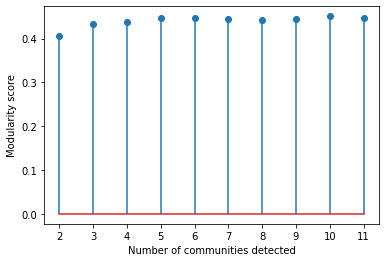

Start to assess hompohily
--------------------------------------------------------------------------------
Descriptive statistics on observed-simulated distances
--------------------------------------------------------------------------------
Mean: 0.04
Std. dev.: 0.01
Min: 0.01
Max: 0.05
([0.03394726939751502, 0.016801711019028387, 0.02501577452074011, 0.02297749818117578, 0.013811843702145943, 0.015773564598754453, 0.022363849609508768, 0.021664664623959884, 0.024584500343173277, 0.020634141737513656, 0.02094591746196761, 0.025602560387918305, 0.029872932245684547, 0.029018709080696148, 0.030421975959014858, 0.03233807411803635, 0.03206597784438825, 0.03734438786329575, 0.0378389357002783, 0.041719840550250686, 0.044579119247982746, 0.04657588828452974, 0.04490560018902656, 0.0473125211739126, 0.049127812290237216, 0.04820862031593709, 0.049116096284935074, 0.049822175311602046, 0.04921616625851599, 0.04690585859010188, 0.04791128740204742, 0.04824990254409067, 0.04920964271693984, 0

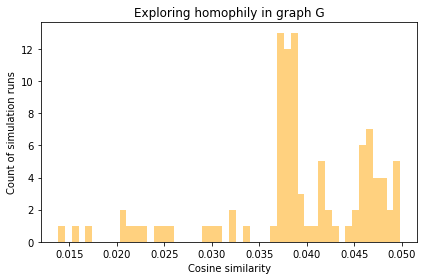

In [12]:
# get the results
data = StarWarsCharacter().get_labeled_characters()
swn = StarWarsNetwork(data)
swn.plot_modularity_scores()
print(swn.assess_homopohily(100))